In [1]:
"""
Author: Surabhi S Nath
Description: This script implements descriptive analysis on the data.
"""

'\nAuthor: Surabhi S Nath\nDescription: This script implements descriptive analysis on the data.\n'

In [149]:
import numpy as np
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json
import matplotlib
import random
random.seed(1)
import scipy.stats
import sys
sys.path.insert(1, '../../measures/intricacy/')
from calculate_intricacy import *
sys.path.insert(1, '../../measures/local spatial complexity/')
from calculate_local_spatial_complexity import *
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
sns.set(font_scale=1.5, font="serif")
pd.set_option('display.max_colwidth', 10000)

In [150]:
def matrix_to_pattern(p):
    ratio = 22
    new_data = np.zeros(np.array(p.shape) * ratio)
    for j in range(p.shape[0]):
        for k in range(p.shape[1]):
            if p[j, k] == 2:
                new_data[j * ratio: (j+1) * ratio, k * ratio: (k+1) * ratio] = 2
            elif p[j, k] == 1:
                new_data[j * ratio: (j+1) * ratio, k * ratio: (k+1) * ratio] = 1
            elif p[j, k] == 0:
                new_data[j * ratio: (j+1) * ratio, k * ratio: (k+1) * ratio] = 0
    cmap = matplotlib.colors.ListedColormap([cmapmap[i] for i in np.unique(new_data)])
    plt.imshow(new_data, cmap=cmap)
    plt.axis('off')
    plt.show()

In [151]:
pattern_stats = pd.read_csv("../../csvs/grid-search/pattern_stats.csv")
grid_data = pd.read_csv("../../csvs/grid-search/grid_data_reevaluatedforreproduction.csv")
click_data = pd.read_csv("../../csvs/grid-search/click_data_reevaluatedforreproduction.csv")
click_data_all = pd.read_csv("../../csvs/grid-search/click_data_all.csv")

num_participants = 29
grid_size = 27
cmapmap = {0: "white", 1: "black", 2:"gray"}

## Correlations

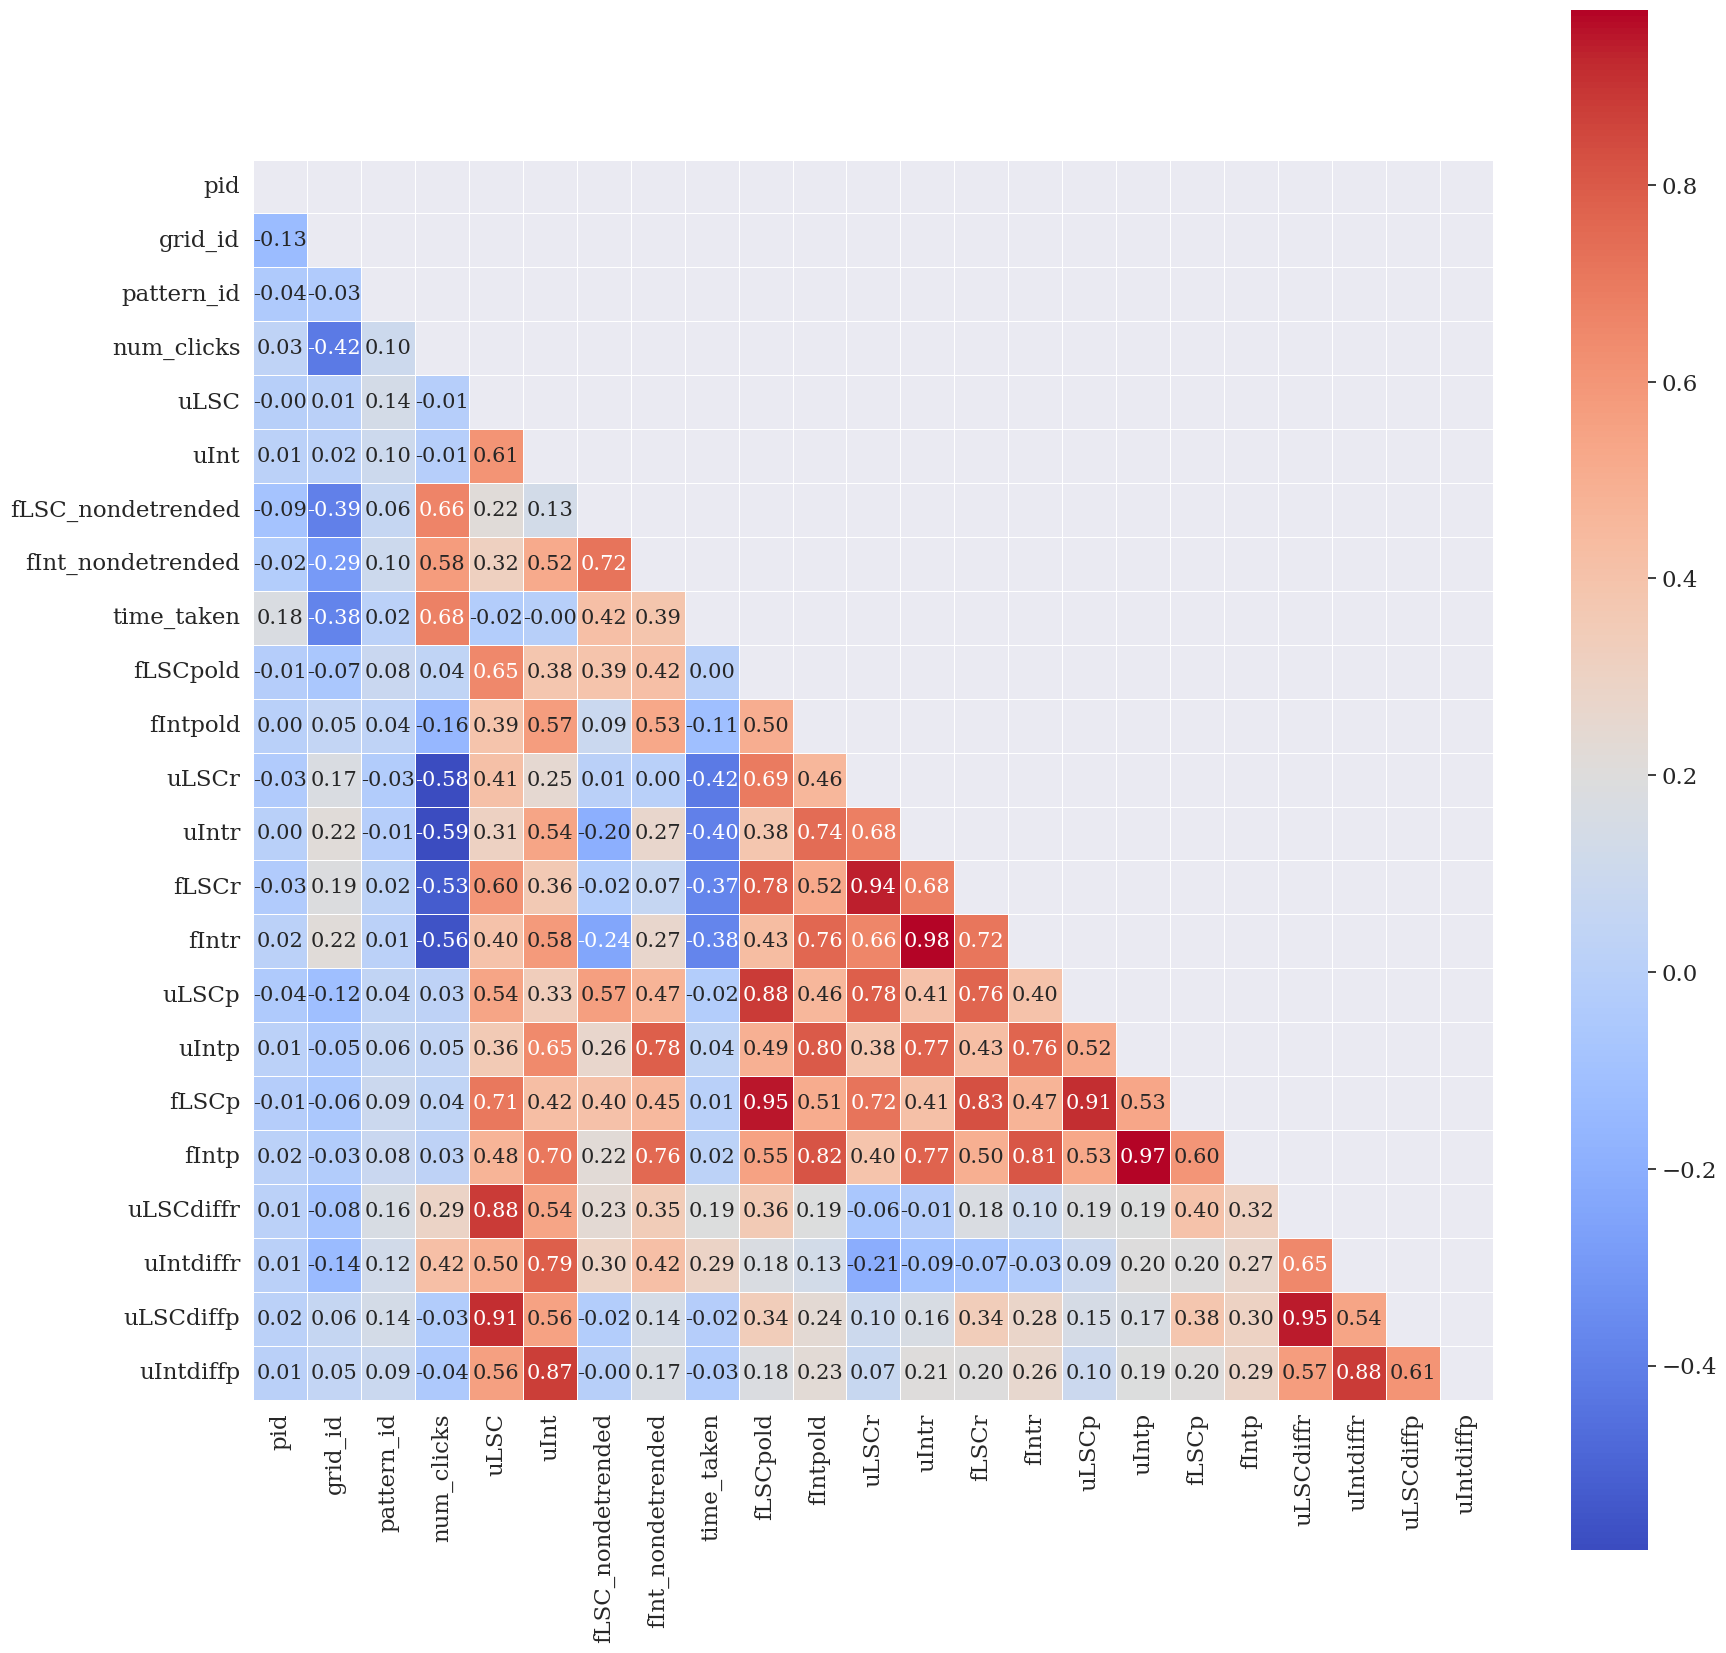

In [89]:
corr_matrix = grid_data.select_dtypes(include=[np.number]).corr(method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 15}, fmt=".2f");

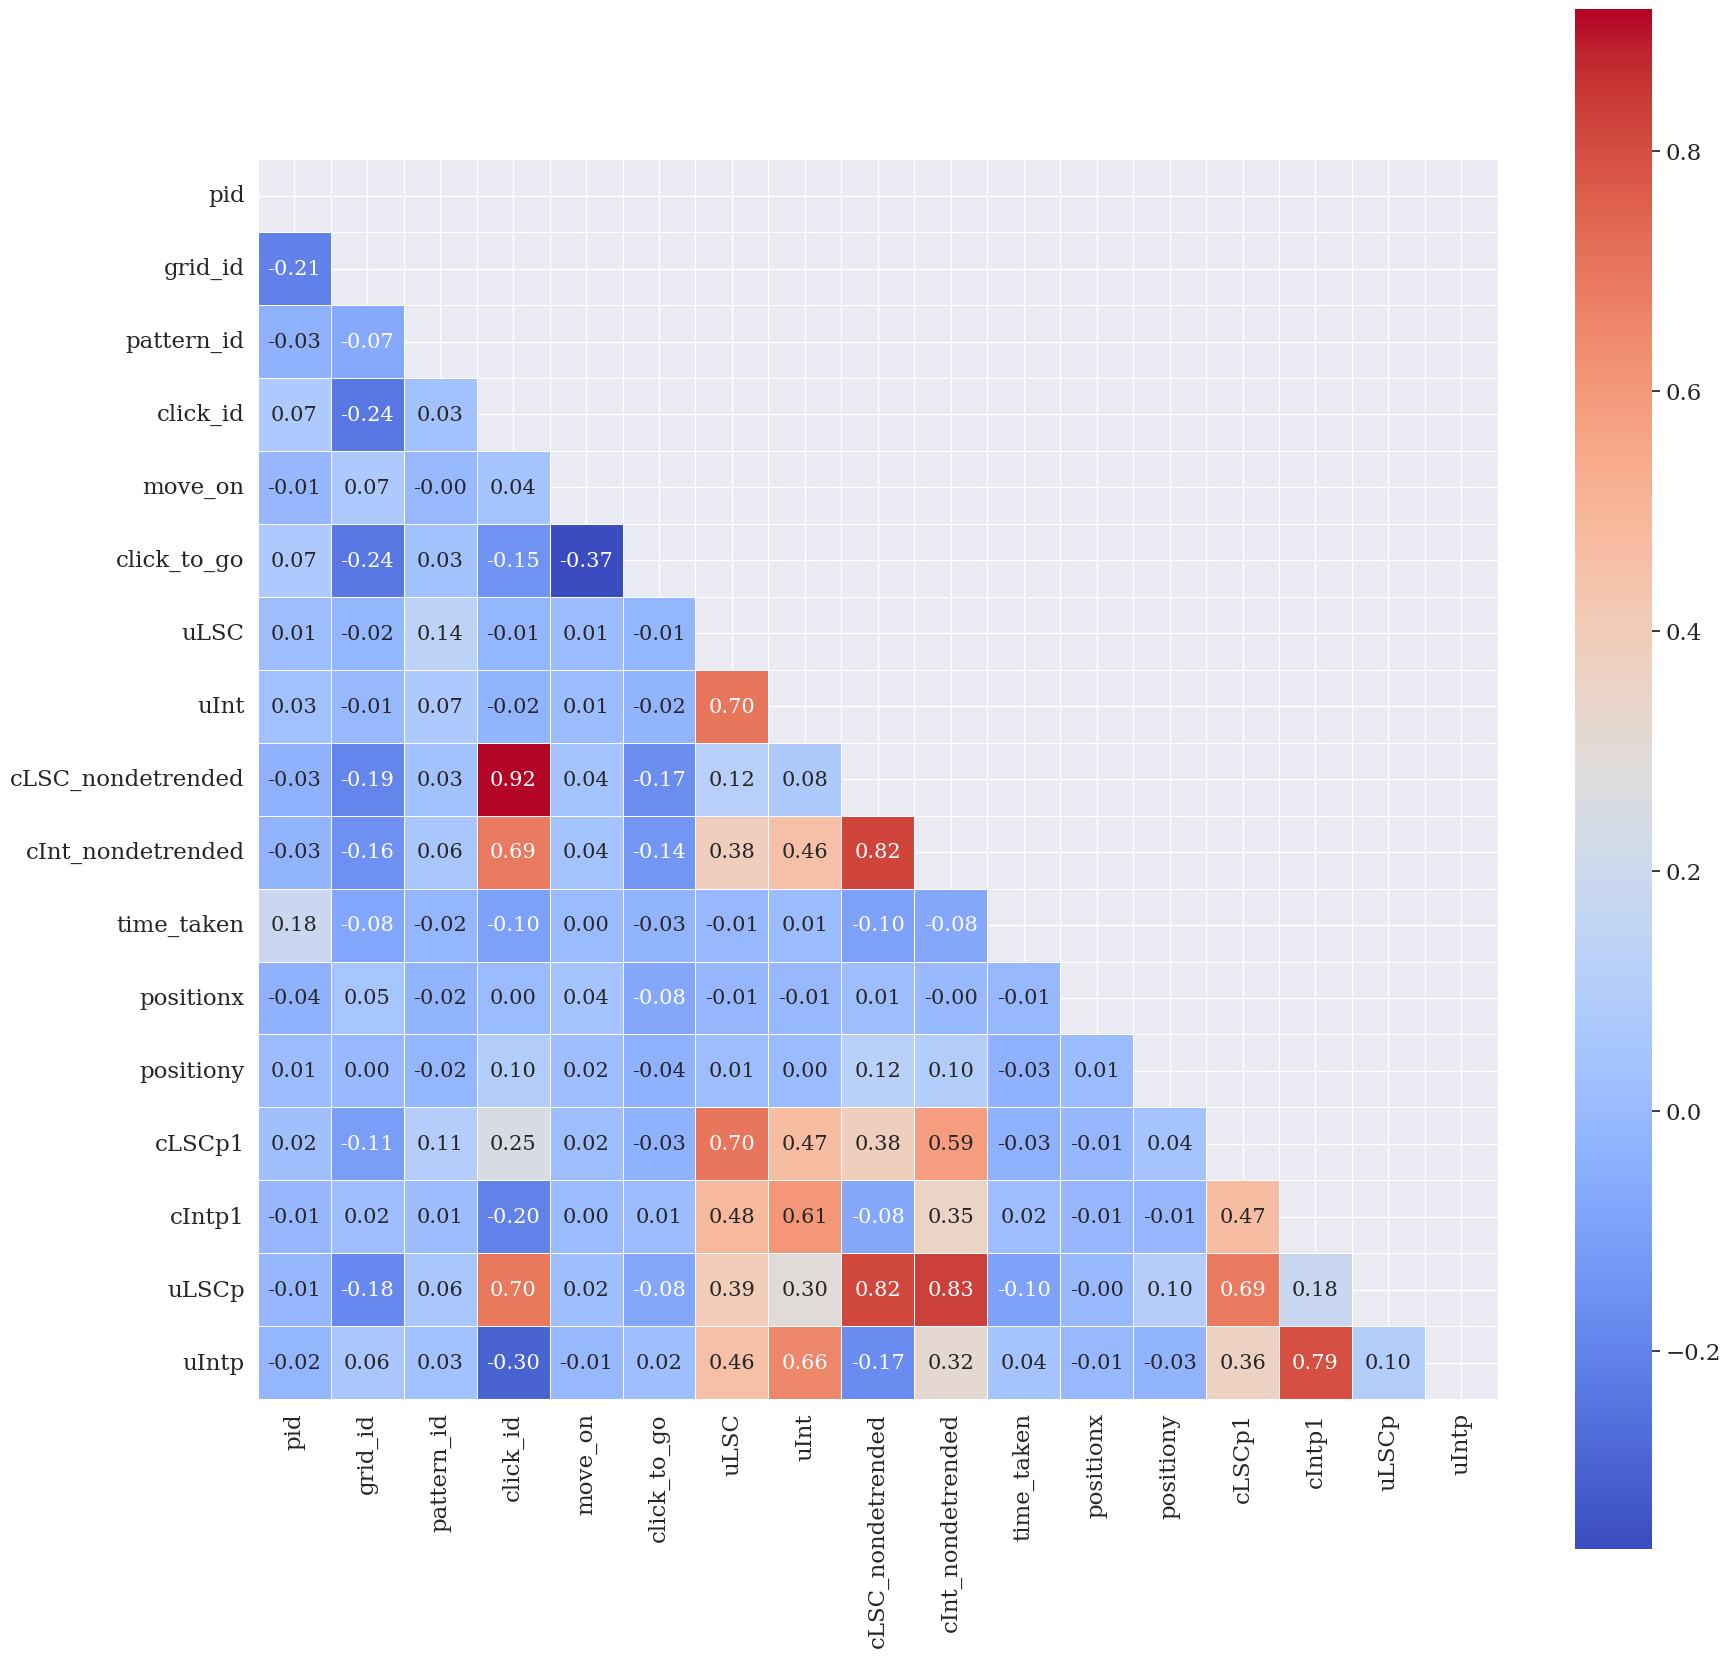

In [5]:
corr_matrix = click_data.select_dtypes(include=[np.number]).corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 15}, fmt=".2f");

## Click time analysis

Percent outliers: 2.0472907237426505


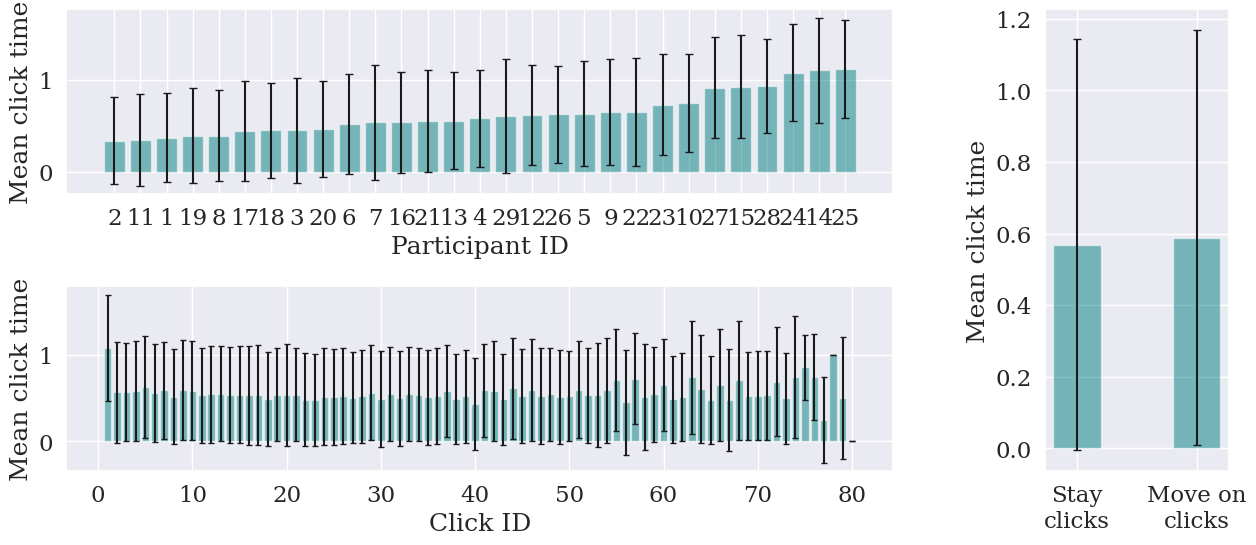

In [6]:
Q1 = click_data["time_taken"].quantile(0.25)
Q3 = click_data["time_taken"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

percent_outliers = len(click_data[click_data["time_taken"] > upper_bound]) / len(click_data) * 100
print("Percent outliers:", percent_outliers)
click_data_nooutliertimes = click_data[click_data["time_taken"] < upper_bound]

grouped_data_pid = click_data_nooutliertimes[["pid", "time_taken"]].groupby("pid").agg(['mean', 'std'])["time_taken"]
grouped_data_clickid = click_data_nooutliertimes[["click_id", "time_taken"]].groupby("click_id").agg(['mean', 'std'])["time_taken"].reset_index()
sorted_data = grouped_data_pid.sort_values("mean").reset_index()

# Plotting
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4.5, 1], height_ratios=[1, 1], wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(
    list(map(str, sorted_data["pid"].values)),
    sorted_data["mean"].values,
    yerr=sorted_data["std"].values,
    capsize=3,
    color='teal',
    alpha=0.5
)
ax0.set_xlabel("Participant ID")
ax0.set_ylabel("Mean click time")

ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(
    grouped_data_clickid["click_id"],
    grouped_data_clickid["mean"].values,
    yerr=grouped_data_clickid["std"].values,
    capsize=2,
    color='teal',
    alpha=0.5
)
ax1.set_xlabel("Click ID")
ax1.set_ylabel("Mean click time")

ax2 = fig.add_subplot(gs[:, 1])
ax2.bar(["Stay\nclicks", "Move on\nclicks"], 
        [click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 0]["time_taken"].mean(), click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 1]["time_taken"].mean()], 
        yerr=[click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 0]["time_taken"].std(), click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 1]["time_taken"].std()],
        capsize=3,
        color='teal',
        width=0.4,
        alpha=0.5
    )
ax2.set_ylabel("Mean click time")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.1)

plt.tight_layout()

## Order of Grid Opening

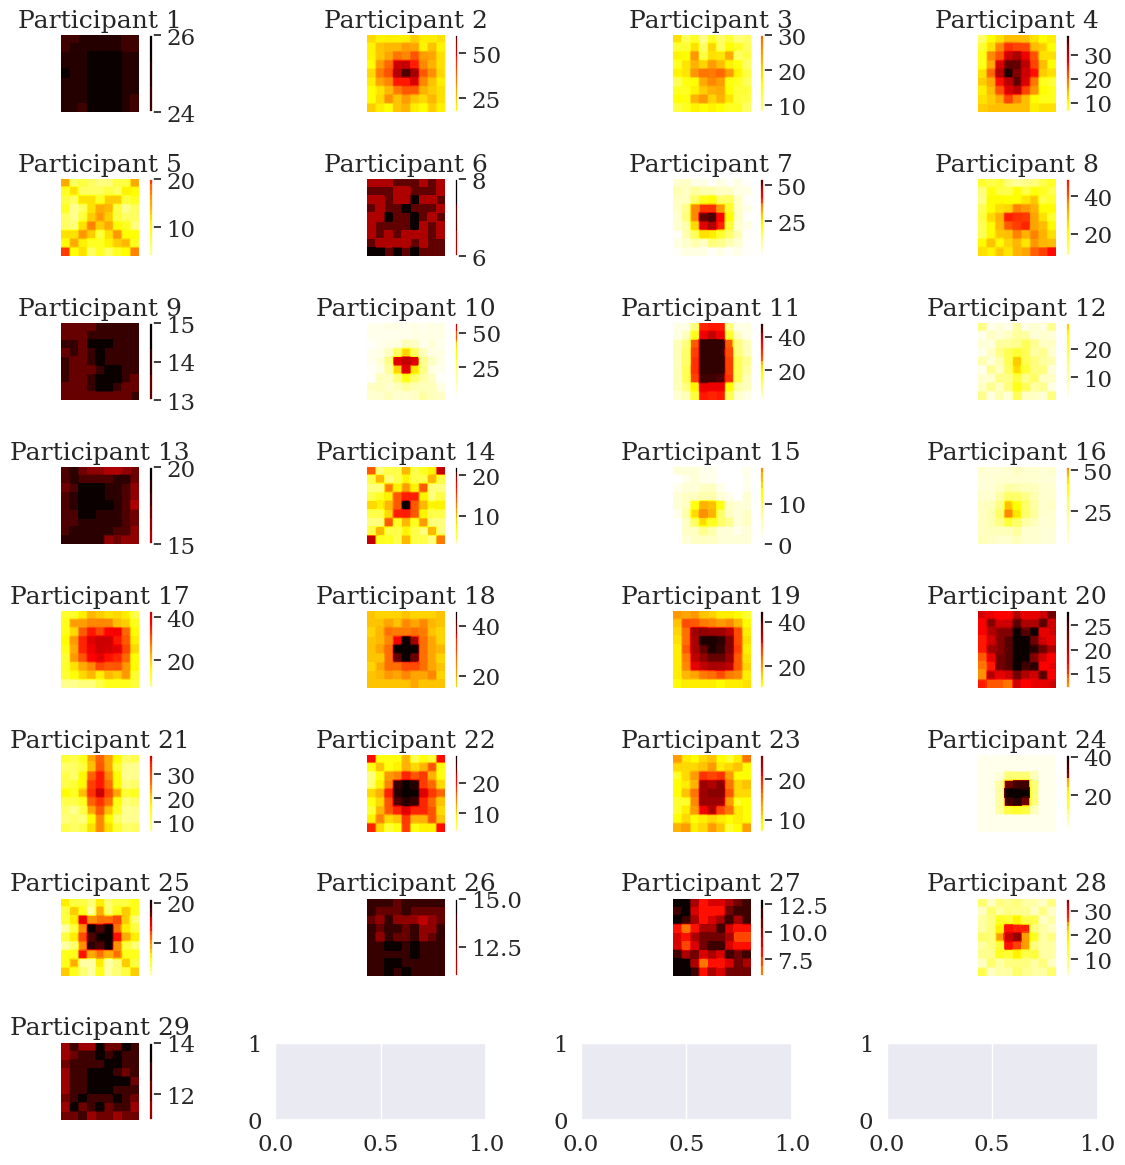

In [7]:
colmaptemp = matplotlib.cm.get_cmap('hot_r')
heatmap_colours = {}
for c in range(101):
    heatmap_colours[c] = colmaptemp(c * (1/100))
    
fig, axs = plt.subplots(8, 4, figsize=(12,12))
for sub in range(num_participants):
    cpx = click_data_all[click_data_all["pid"] == sub + 1]["positionx"].values
    cpy = click_data_all[click_data_all["pid"] == sub + 1]["positiony"].values
    heatmap = np.zeros((grid_size, grid_size))
    for pos in zip(cpx, cpy):
        if pos[0] % 3 == 0:
            xpos = [pos[0], pos[0] + 1, pos[0] + 2]
        elif pos[0] % 3 == 1:
            xpos = [pos[0] - 1, pos[0], pos[0] + 1]
        elif pos[0] % 3 == 2:
            xpos = [pos[0] - 2, pos[0] - 1, pos[0]]
        if pos[1] % 3 == 0:
            ypos = [pos[1], pos[1] + 1, pos[1] + 2]
        elif pos[1] % 3 == 1:
            ypos = [pos[1] - 1, pos[1], pos[1] + 1]
        elif pos[1] % 3 == 2:
            ypos = [pos[1] - 2, pos[1] - 1, pos[1]]

        for xind in xpos:
            for yind in ypos:
                heatmap[xind, yind] += 1
    colmap = matplotlib.colors.ListedColormap([heatmap_colours[int(i)] for i in np.unique(heatmap)*100//len(grid_data[grid_data["pid"] == sub + 1])  ])  
    axs[int(sub/4), sub%4].imshow(heatmap, cmap=colmap)
    axs[int(sub/4), sub%4].set_title('Participant ' + str(sub + 1))
    axs[int(sub/4), sub%4].axis('off')
    plt.colorbar(axs[int(sub/4), sub%4].imshow(heatmap, cmap=colmap), ax=axs[int(sub/4), sub%4])
    # plt.colorbar()
fig.tight_layout()

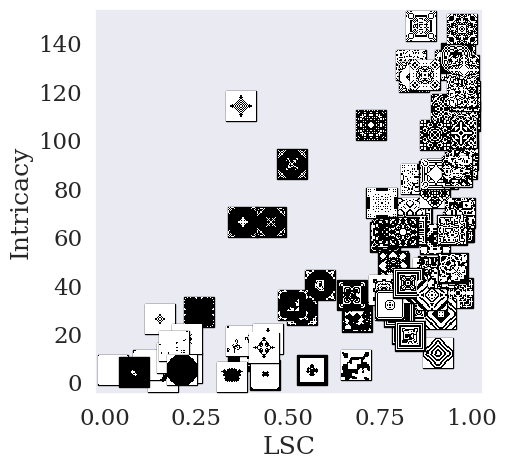

In [8]:
sns.set_style("dark")
plt.rc("font", family="serif")

def get_image(path):
    return OffsetImage(plt.imread(path),  zoom=0.02)  # Adjust zoom as per the image size

# Create the plot
fig, ax = plt.subplots(figsize=(5,5))

# Loop through the DataFrame to place images
for idx, row in pattern_stats.iterrows():
    if row['uInt'] > 150:
        continue
    image_path = os.path.join(f'../../patterns/grid-search/experiment/range{row["range"]}/', row['name'])  # Build the image path
    if os.path.exists(image_path):  # Ensure the file exists
        img = get_image(image_path)
        # ab = AnnotationBbox(img, (row['underlying_LSC'], row['underlying_intricacy']), frameon=False)
        ab = AnnotationBbox(img, (row['uLSC'], row['uInt']), 
                            frameon=True, 
                            bboxprops=dict(edgecolor='black', linewidth=1),
                            pad=0.001)
        ax.add_artist(ab)

# Set labels
ax.set_xlabel('LSC')
ax.set_ylabel('Intricacy')
ax.set_xlim(-0.025, 1.03)
ax.set_ylim(-5, 154)

plt.savefig("plots/LSC_by_intricacy.pdf", format='pdf', dpi=300, bbox_inches='tight');

In [136]:
failures = pd.read_csv("failures.csv")

81 13.9484512949752 40 -0.886452184996111


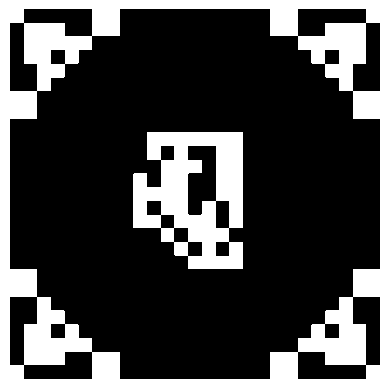

81 16.1619877763868 62 0.0308003465255809


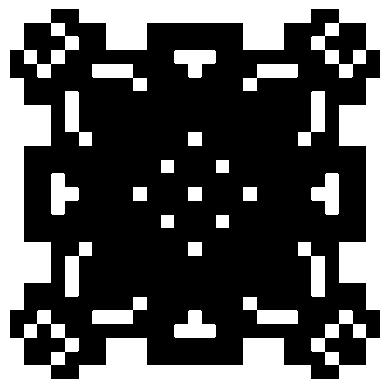

81 17.0469169677746 66 0.197573534074979


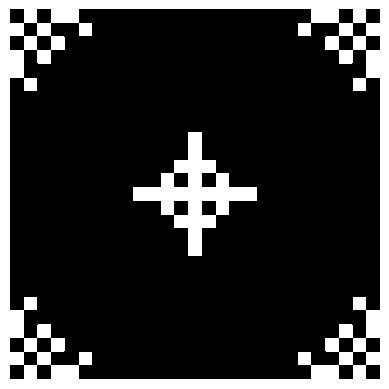

81 17.4644663138304 74 0.531119909173777


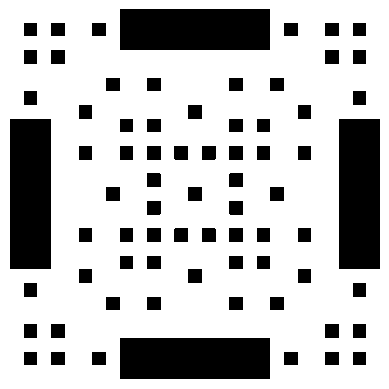

81 17.7147484469545 106 1.86530540956897


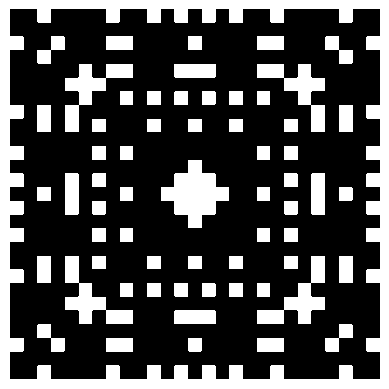

81 18.3045506927787 114 2.19885178466776


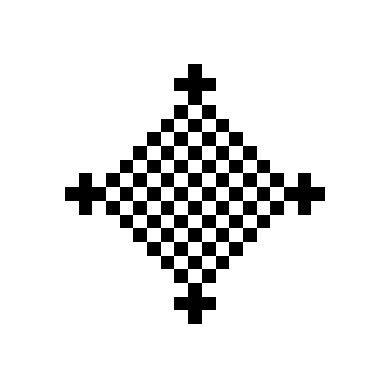

80 18.1496969480131 61 -0.0424920806342862


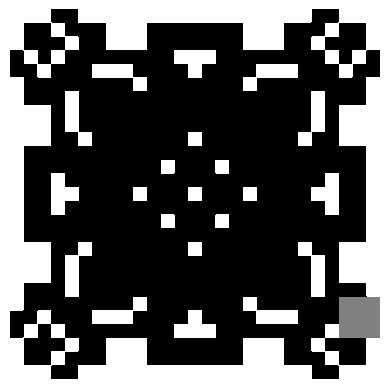

58 -0.27422265438075 151 2.00837924941398


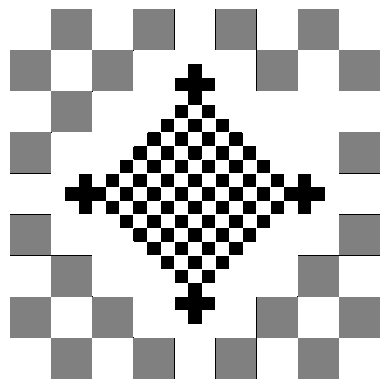

81 22.919772084622 106 1.86530540956897


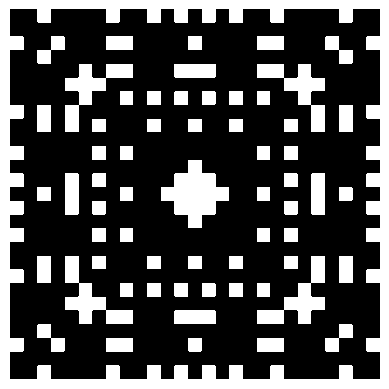

81 25.206702788164 106 1.86530540956897


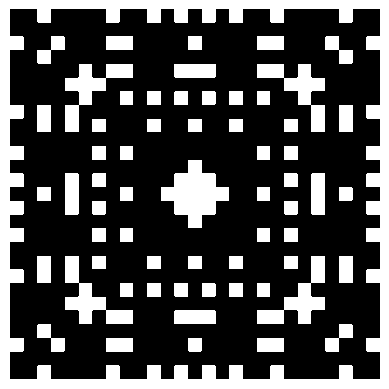

81 25.9306387546699 62 0.0308003465255809


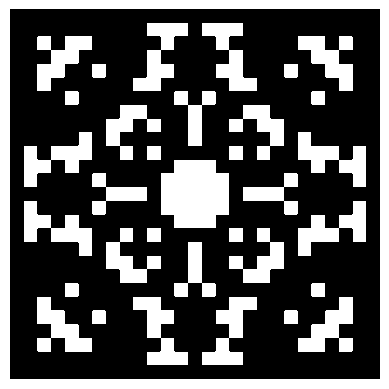

81 26.7139270479772 40 -0.886452184996111


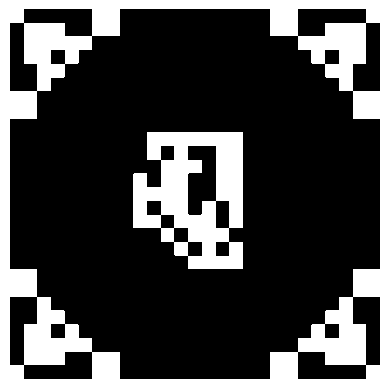

81 26.9844611736454 30 -1.30338515386961


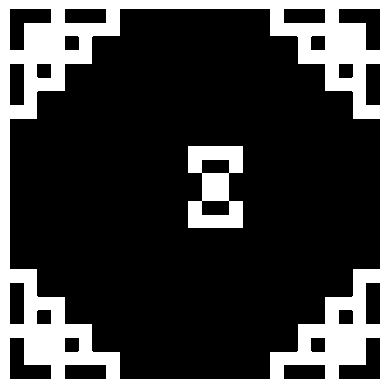

77 24.554056744515 94 1.14510856544117


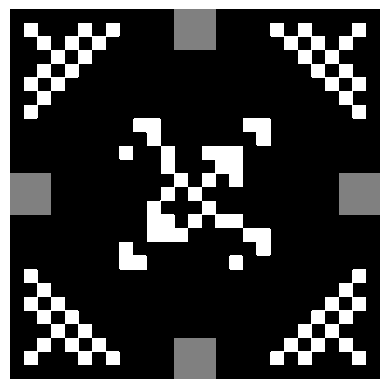

81 30.6090283328558 62 0.0308003465255809


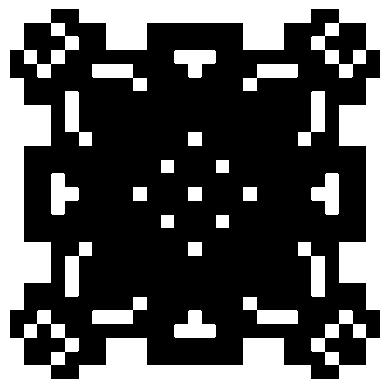

42 90.5012978713909 32 -2.18640529426274


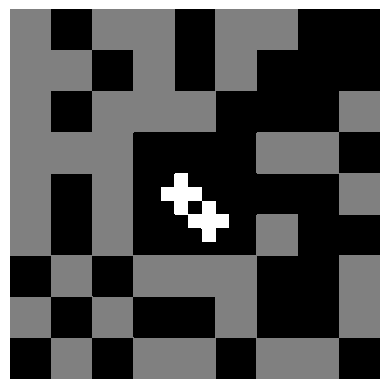

81 32.6492546282999 3 -2.42910416982805


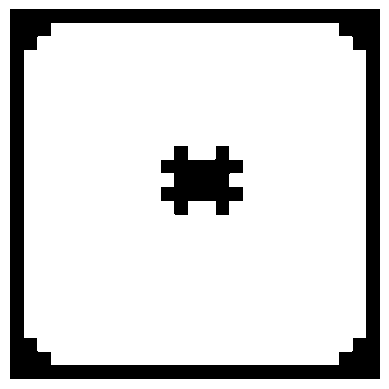

81 33.6751024940462 66 0.197573534074979


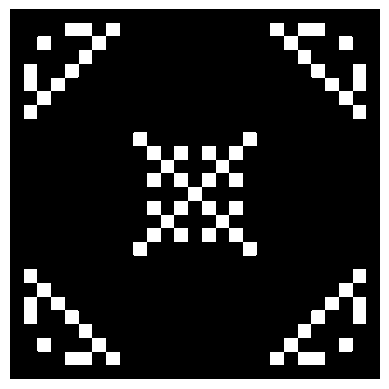

81 34.2201134503498 106 1.86530540956897


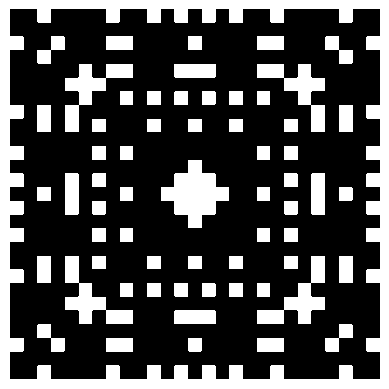

81 35.5724867688 14 -1.9704779040672


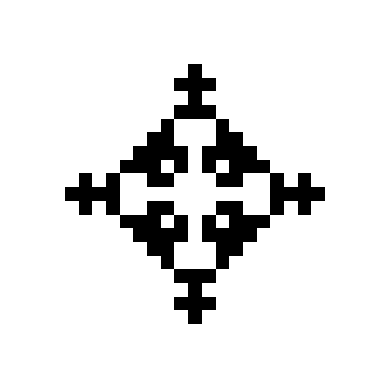

81 37.1287675141917 27 -1.42846504453166


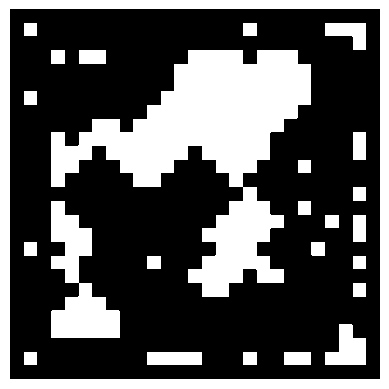

45 1.46092145800951 121 3.11785982342682


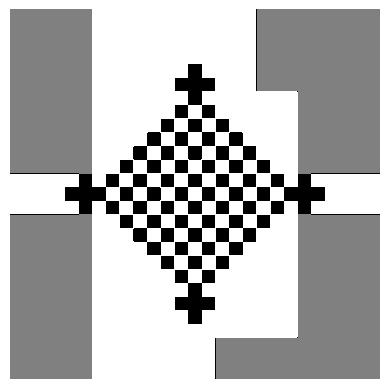

77 33.81453742426 63 -0.0811132398562523


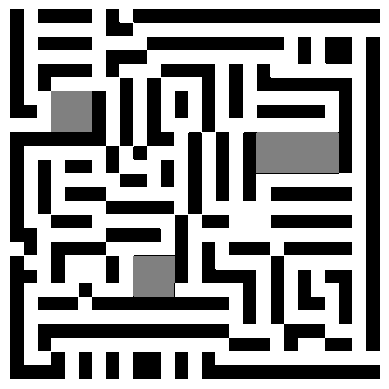

44 86.5585736867195 8 -1.80063257885242


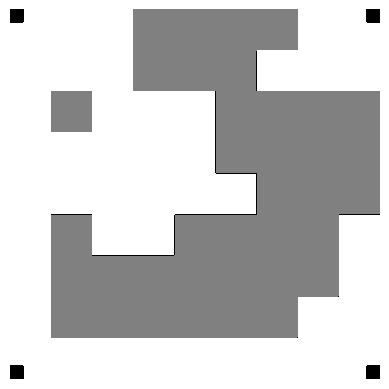

81 38.9374289195562 27 -1.42846504453166


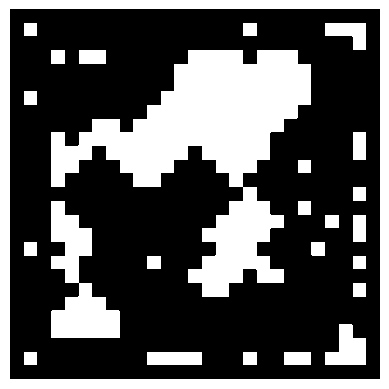

81 40.083583664339 29 -1.34507845075696


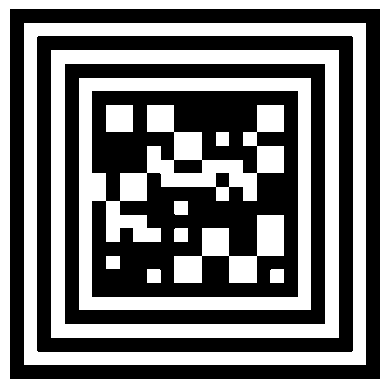

81 40.1766559084257 74 0.531119909173777


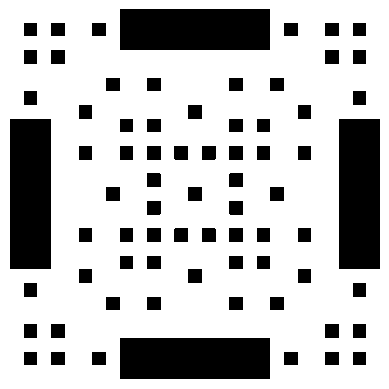

81 40.7399948714918 66 0.197573534074979


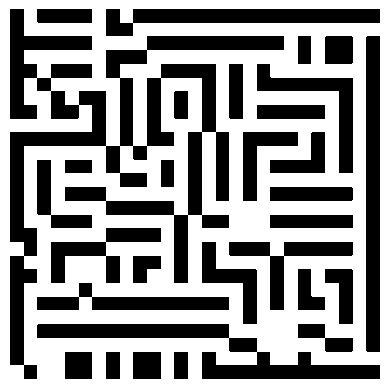

81 41.1572864798716 18 -1.8037047165178


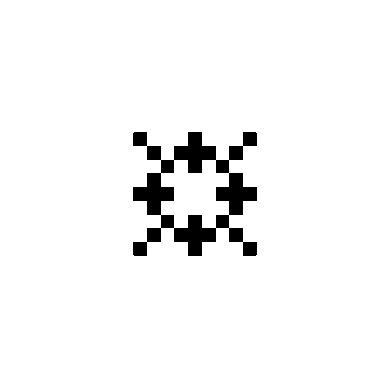

81 41.5988440097815 3 -2.42910416982805


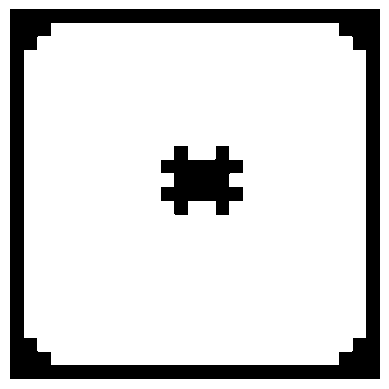

11 49.6767147039142 35 0.485037844193022


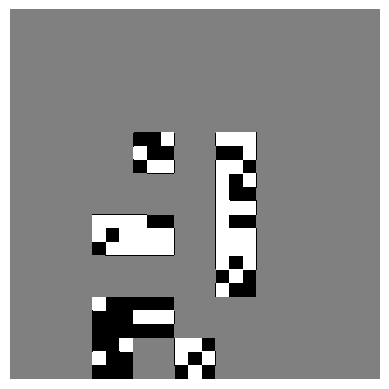

57 95.6366610836686 15 -2.10126319325068


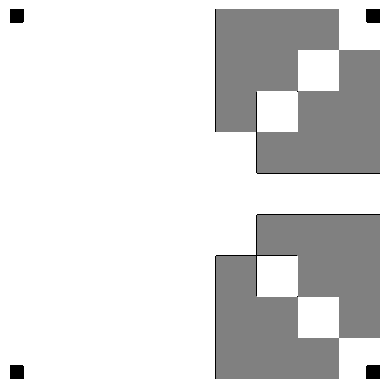

81 43.0644411100095 14 -1.9704779040672


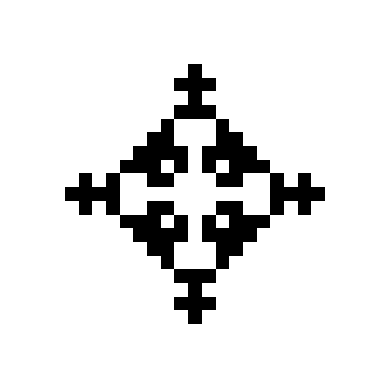

62 24.2763161230843 22 -1.66633627519422


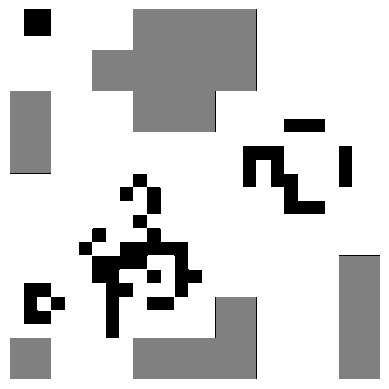

81 44.0783877594799 29 -1.34507845075696


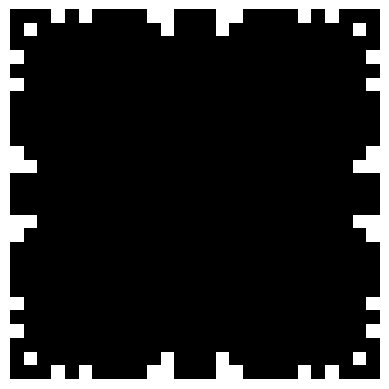

81 44.4002234583143 32 -1.21999856009491


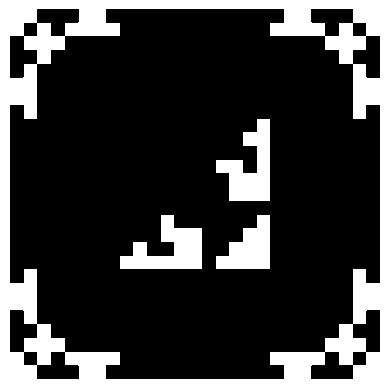

81 44.6747504811336 6 -2.304024279166


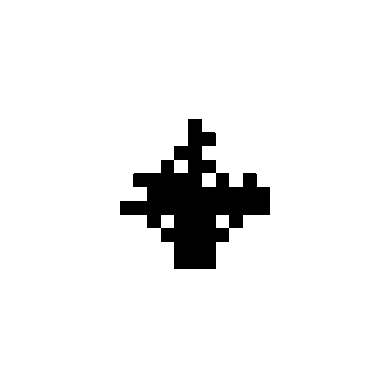

81 45.1471593260692 60 -0.0525862472491184


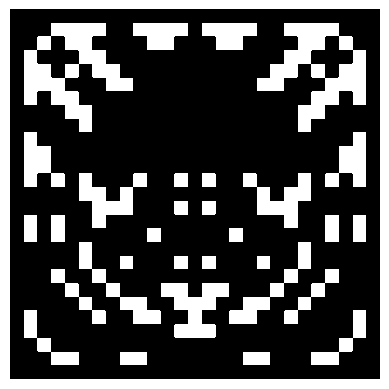

81 45.2891353359817 40 -0.886452184996111


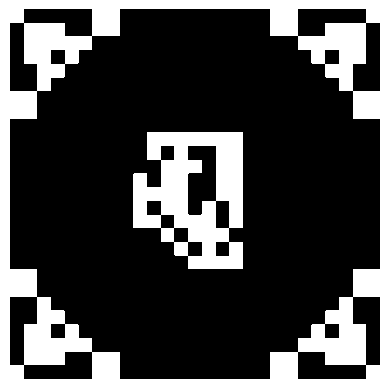

81 116.465854959585 5 -2.34571757605335


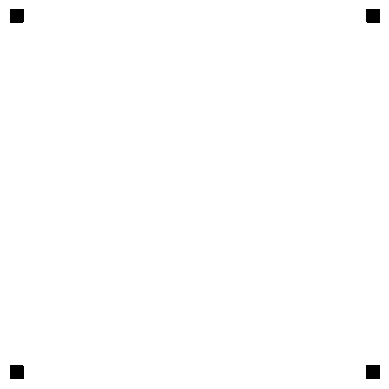

81 45.7348947096496 86 1.03143947182197


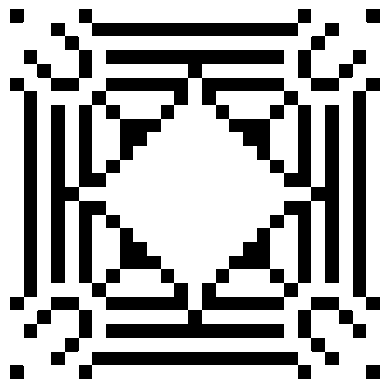

81 116.262211765797 5 -2.34571757605335


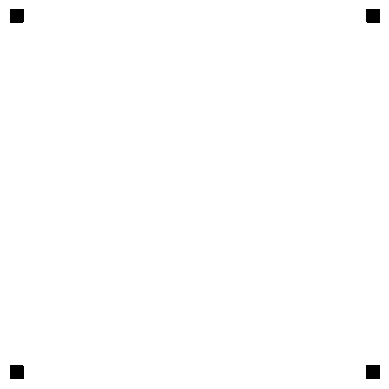

48 13.1937487559994 56 0.143591686526095


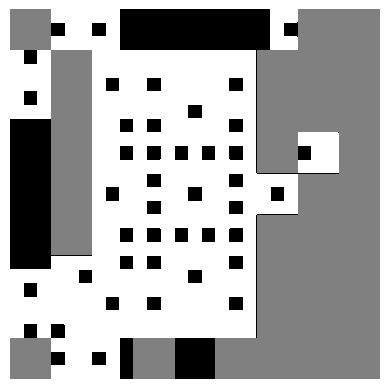

25 59.7757201108421 32 -0.203120992852918


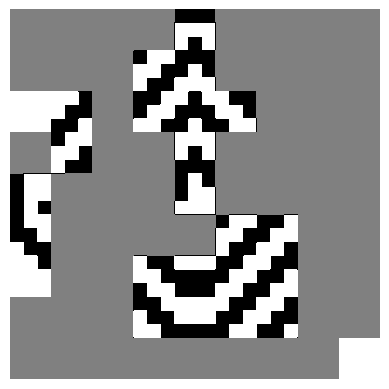

37 2.41469005656641 117 3.18149696078119


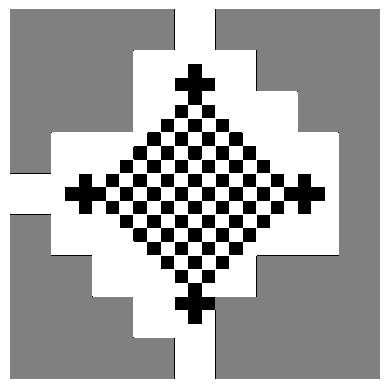

30 64.4752857499459 4 -1.17084435744877


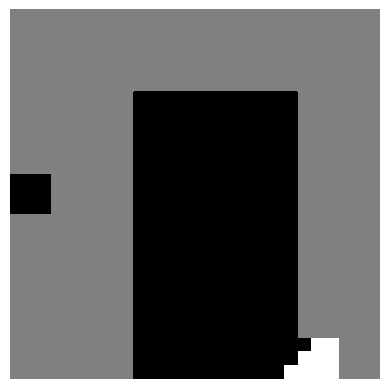

81 46.6873729593618 74 0.531119909173777


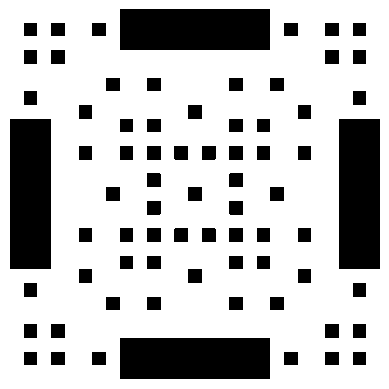

36 69.6127033569542 13 -1.73831207192607


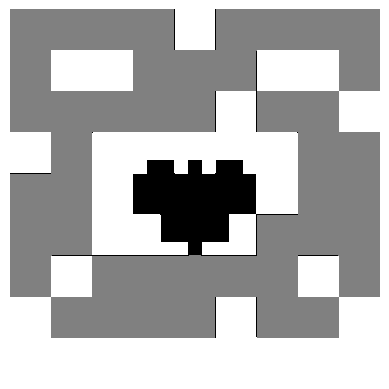

81 47.5979586093543 32 -1.21999856009491


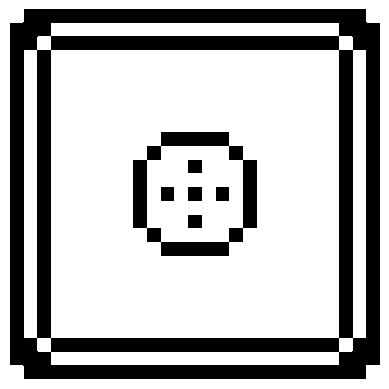

81 47.8719034405811 62 0.0308003465255809


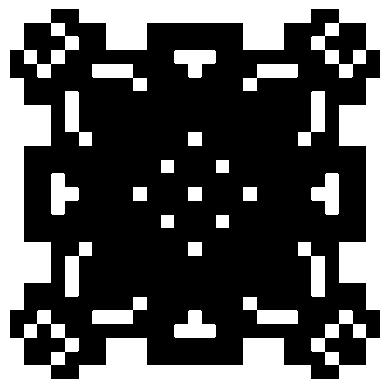

54 87.0653702966283 156 4.24138445533855


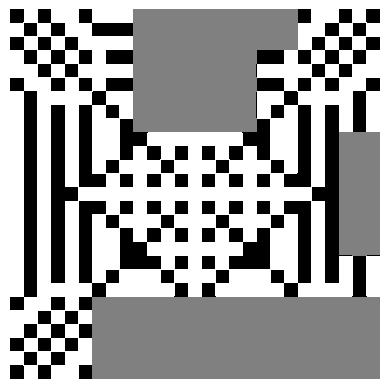

75 42.1635206767987 31 -1.31962359581521


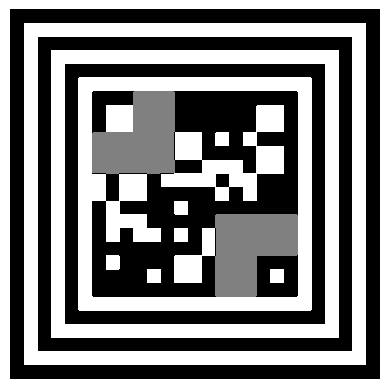

81 48.2619173605186 85 0.989746174934623


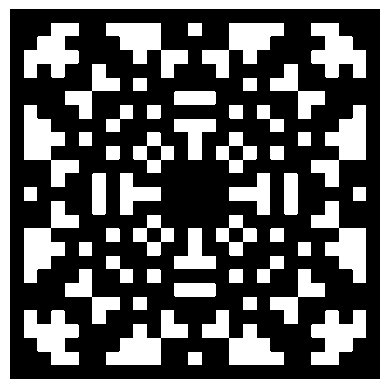

44 11.375610064272 78 -0.128073058455688


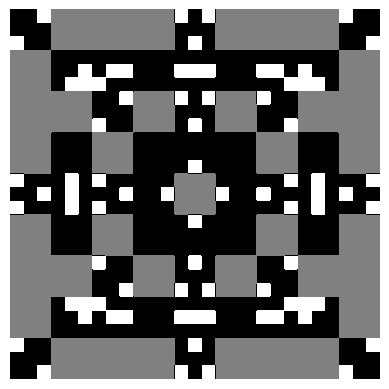

81 48.4623494983478 11 -2.09555779472925


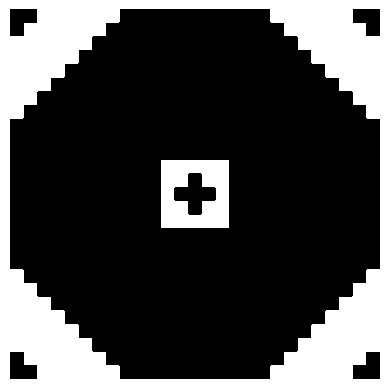

81 48.5605202550809 86 1.03143947182197


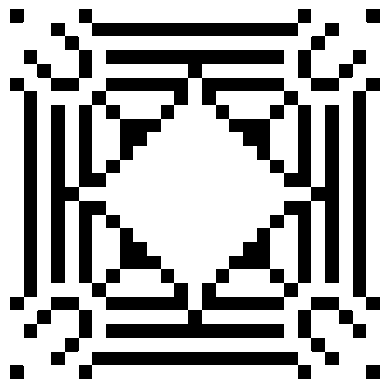

81 48.8714807950492 30 -1.30338515386961


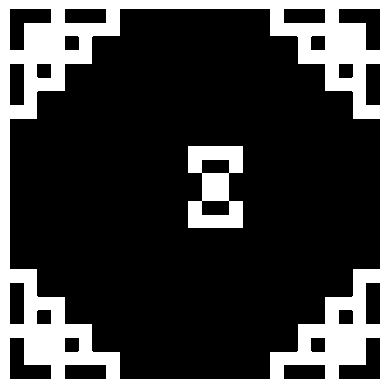

69 37.1237881148052 59 0.0136841509613007


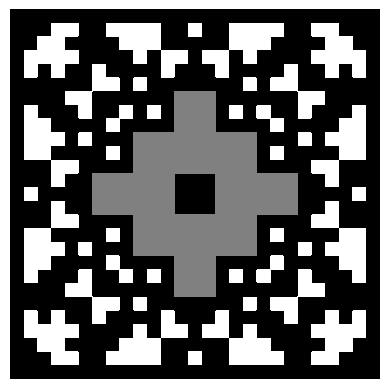

81 49.1418828168943 78 0.697893096723175


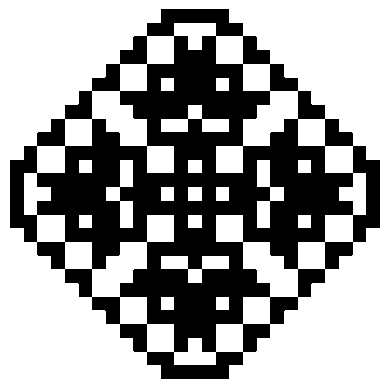

81 49.27586749592 32 -1.21999856009491


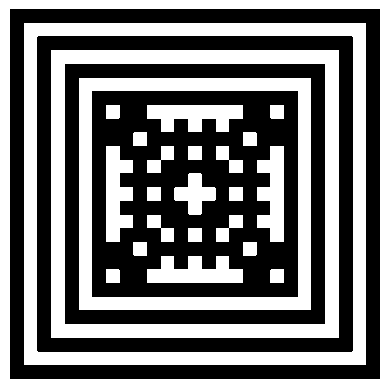

81 49.4161372997624 63 0.0724936434129305


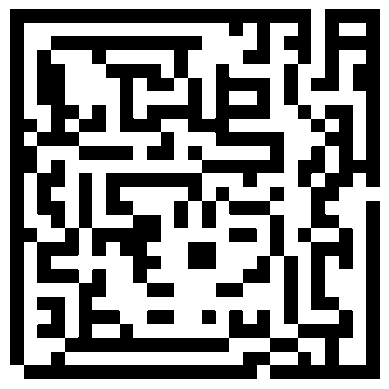

69 37.6057816014163 100 1.29827657190101


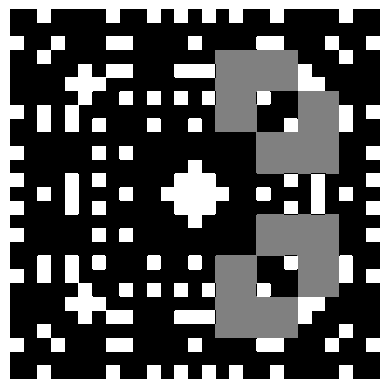

81 112.266551460905 177 4.82552948857079


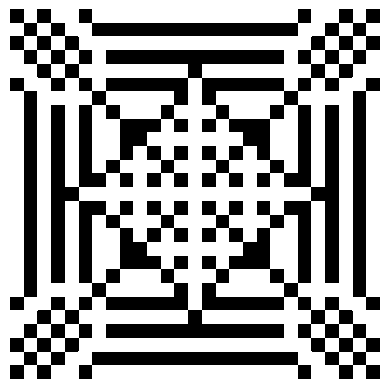

48 16.8380176141236 74 0.603534582714963


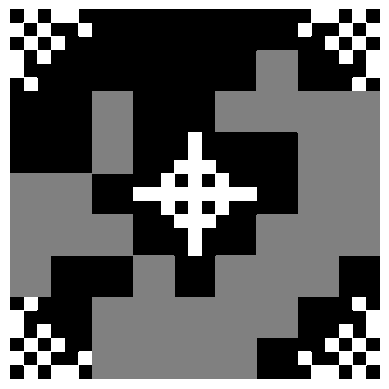

81 49.9794539114124 29 -1.34507845075696


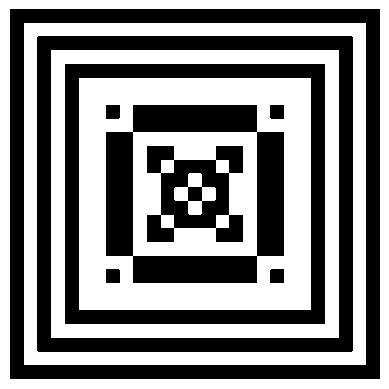

81 50.2689590727703 15 -1.92878460717985


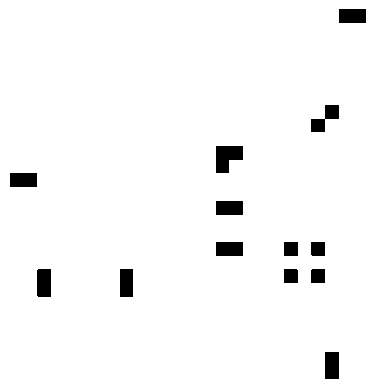

53 22.4616202391605 61 0.699209727151197


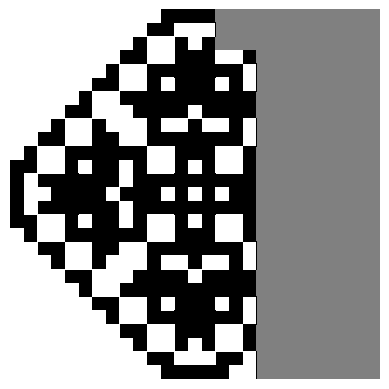

81 50.483743355107 62 0.0308003465255809


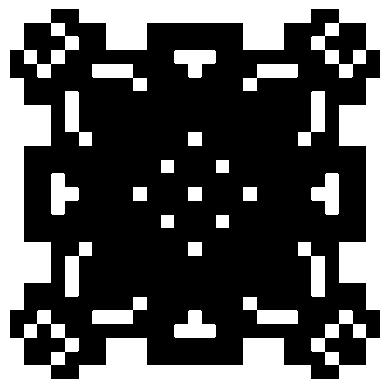

81 50.6873865488951 62 0.0308003465255809


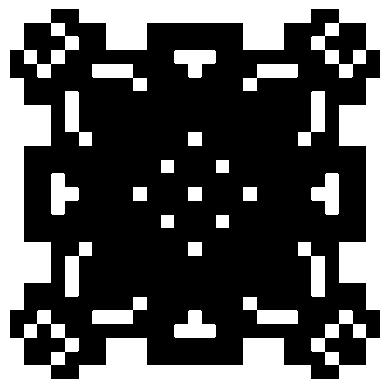

75 104.975344427226 6 -2.40847695978904


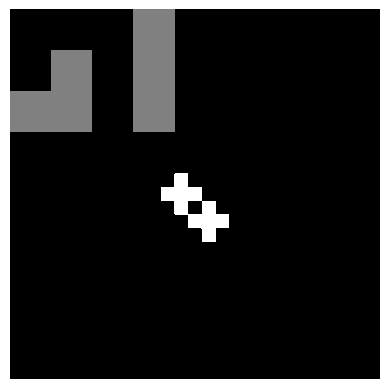

36 6.26682664959495 45 0.581151865438596


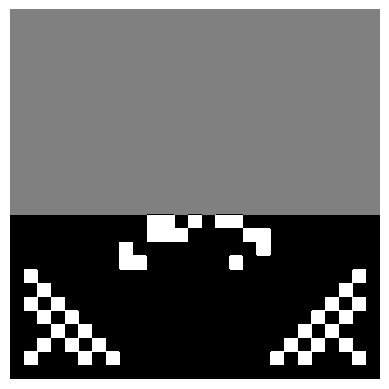

58 28.5792802412951 45 -0.327762006705626


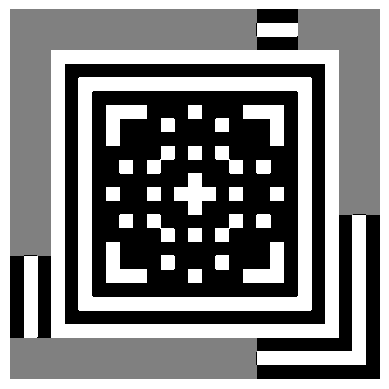

34 63.3031085484572 8 -1.63561489854038


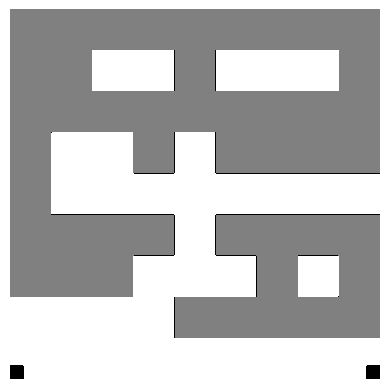

81 52.0773917598801 36 -1.05322537254551


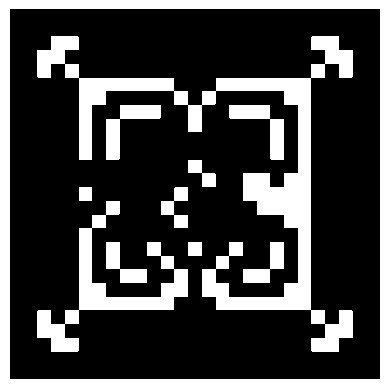

48 19.4219404845375 5 -1.62069308702281


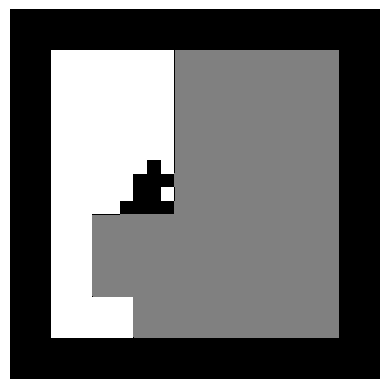

45 16.8104492817989 28 -0.52393994048084


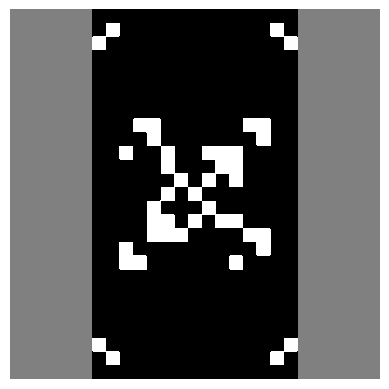

72 44.0391810153669 40 -0.679302330987385


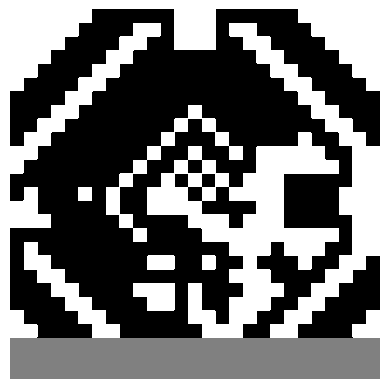

81 53.2888508601666 27 -1.42846504453166


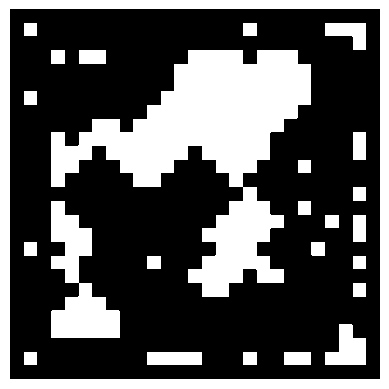

68 95.6927455294616 8 -2.18069989574131


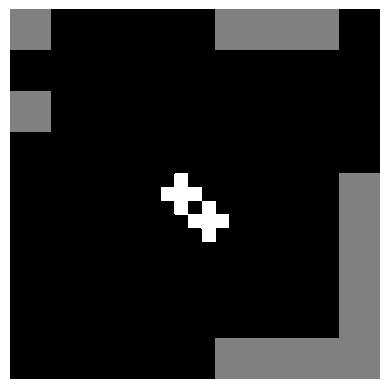

80 52.5530116488624 11 -2.12627917138309


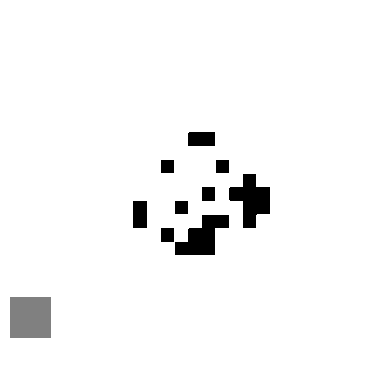

81 53.6543626153456 29 -1.34507845075696


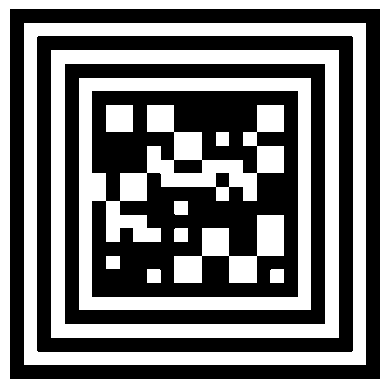

44 71.0364608402942 21 -1.66984728966894


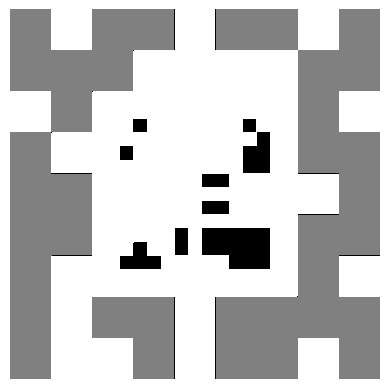

81 54.5952546592341 5 -2.34571757605335


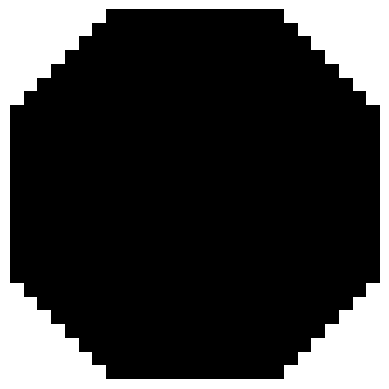

37 10.9859115269948 32 -0.453719650986356


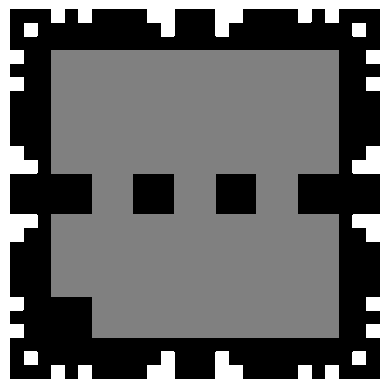

81 55.1086207930247 17 -1.84539801340515


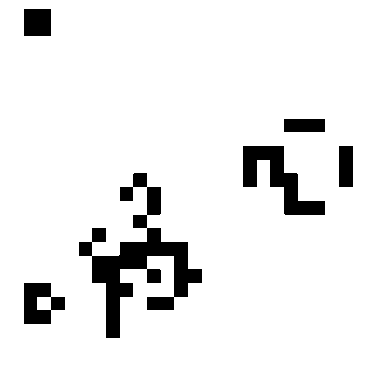

81 55.2769465015753 120 2.44901156599186


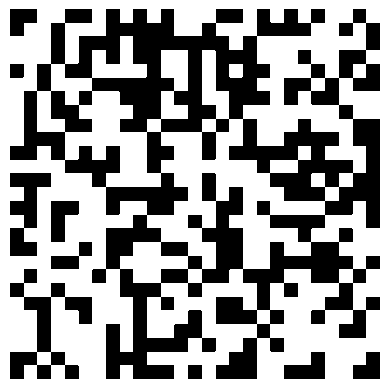

81 55.3030193141591 36 -1.05322537254551


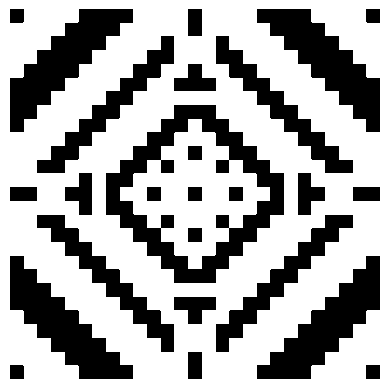

9 34.6658464674414 4 -0.443186607562183


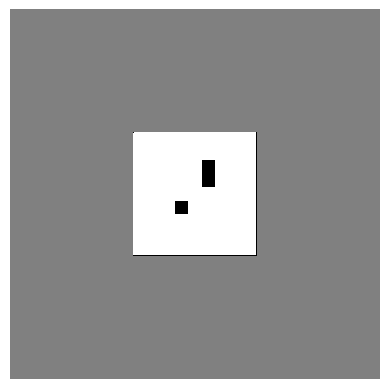

59 33.5446073083302 46 -0.223748202891922


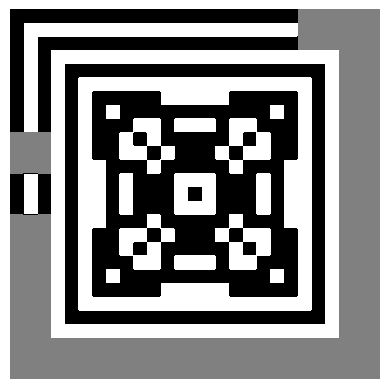

41 15.554644056424 52 -0.462497187173167


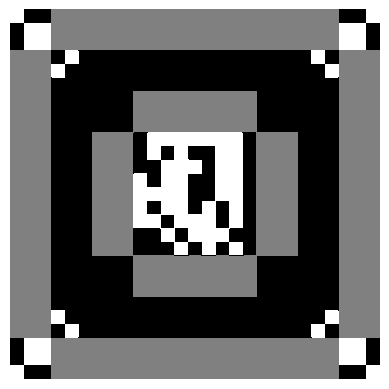

4 29.277738809174 11 0.111114802634897


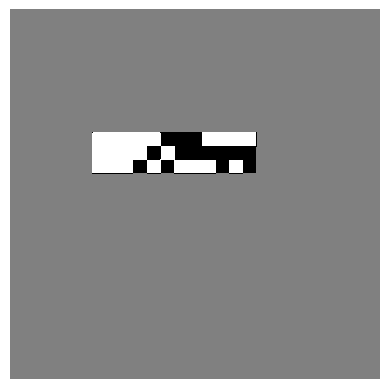

63 37.7832223887849 79 0.604851213142985


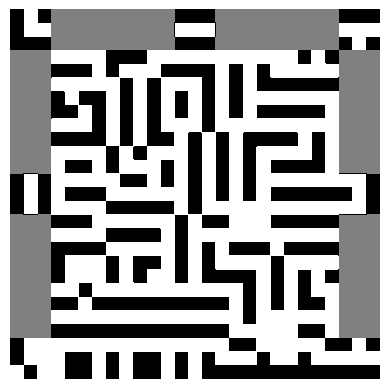

81 106.191407801869 4 -2.3874108729407


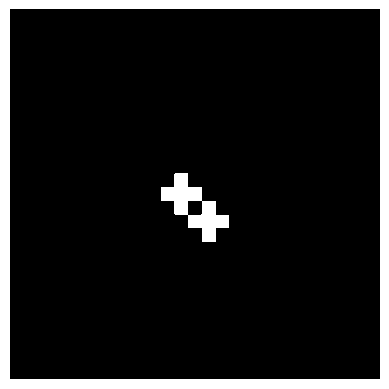

53 27.9042412358797 50 -0.497607331920408


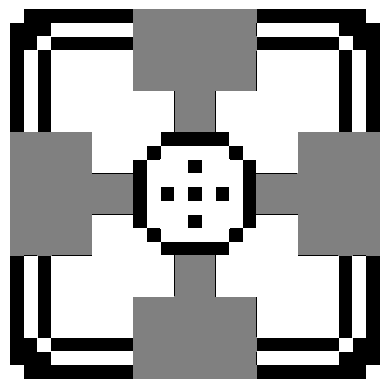

68 42.955917121394 91 1.10253751493514


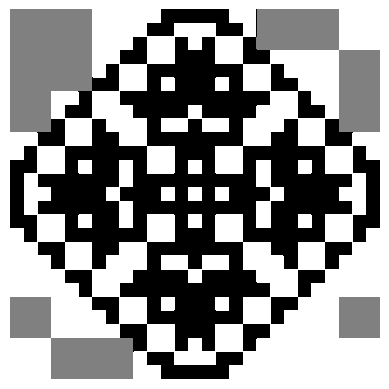

81 56.0792785275957 45 -0.677985700559363


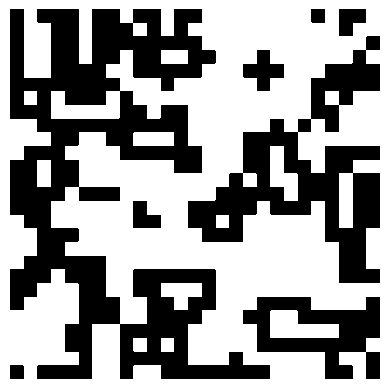

33 57.6348242860196 11 -1.50921837745031


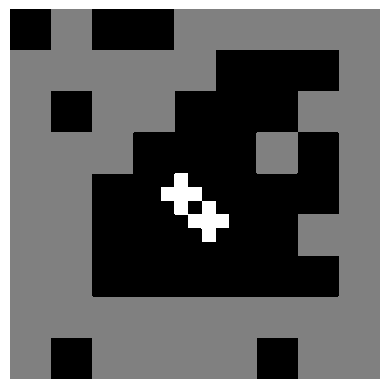

38 62.4020582513317 14 -1.59699373931842


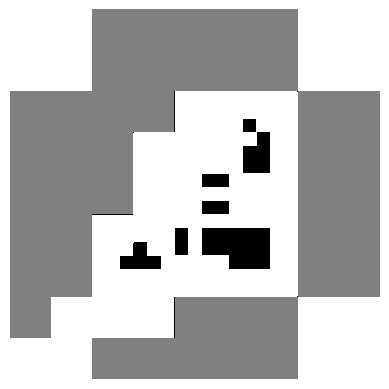

9 33.352315260535 9 -0.234720123125435


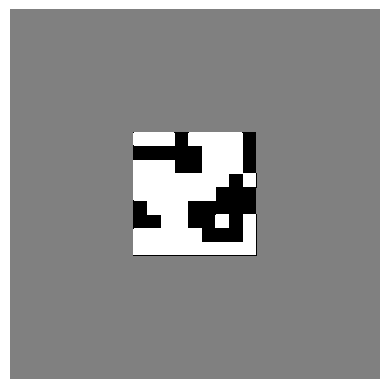

9 33.2886419830091 4 -0.443186607562183


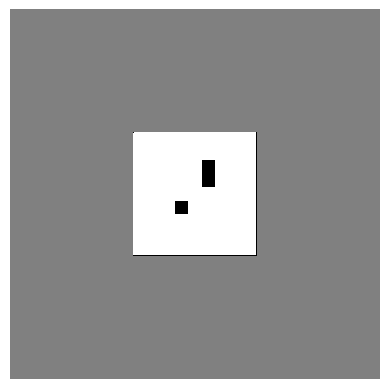

In [139]:
for index, row in failures.iterrows():
    print(row["num_clicks"], row["predicted_clicks"], row["fInt_nondetrended"], row["fIntp"])
    matrix_to_pattern(np.array([int(char) for char in row["final_grid"]]).reshape(grid_size, grid_size))

81 14.6423882172446


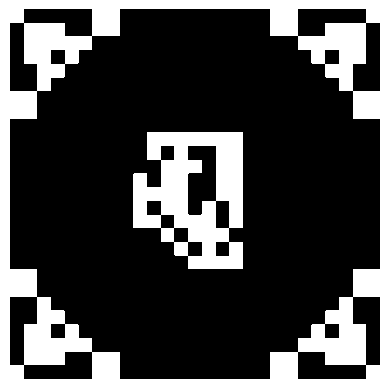

81 16.4153470772988


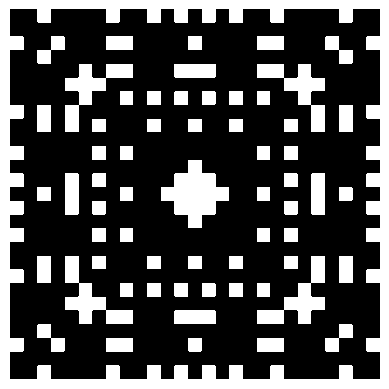

81 16.7912400438497


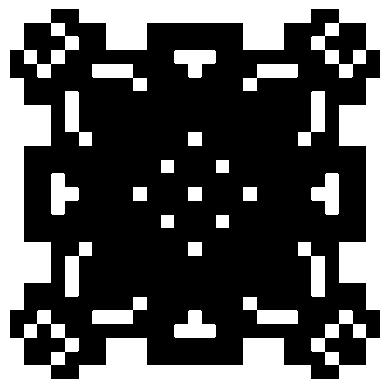

81 17.4039008899476


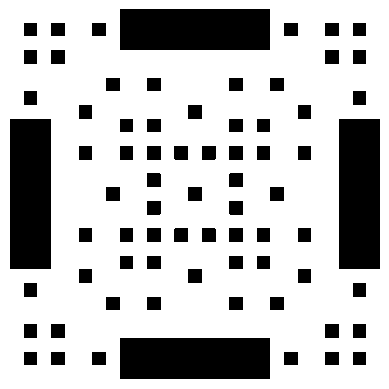

81 18.1667135097241


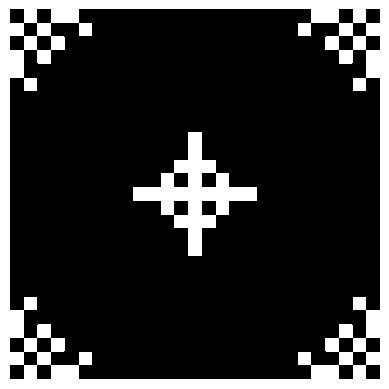

80 18.2930736426721


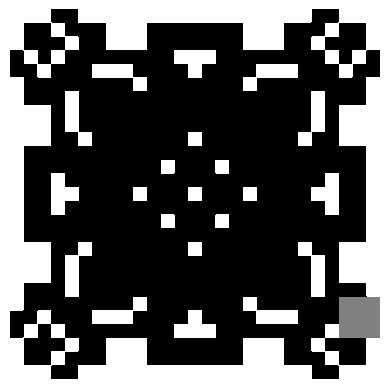

81 20.8893668401934


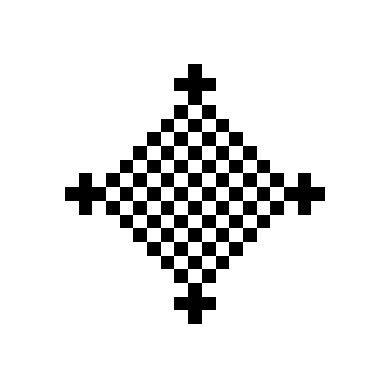

81 22.8118145927256


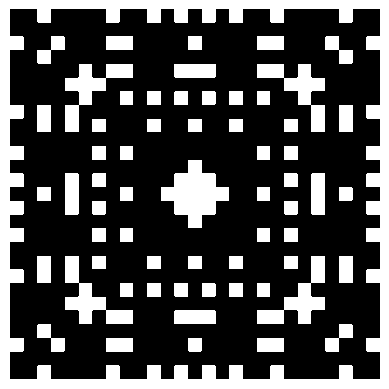

81 23.2531532434481


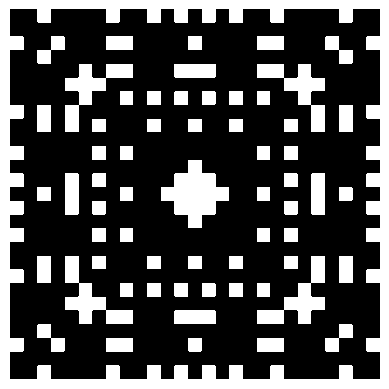

81 137.950733470054


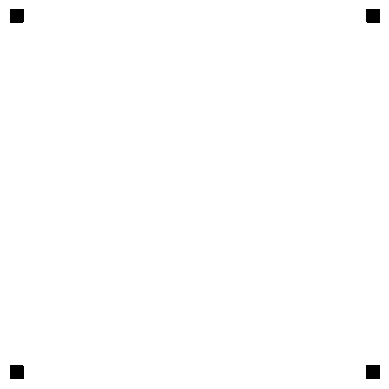

In [132]:
for index, row in failures.iterrows():
    print(row["num_clicks"], row["predicted_clicks"])
    matrix_to_pattern(np.array([int(char) for char in row["final_grid"]]).reshape(grid_size, grid_size))

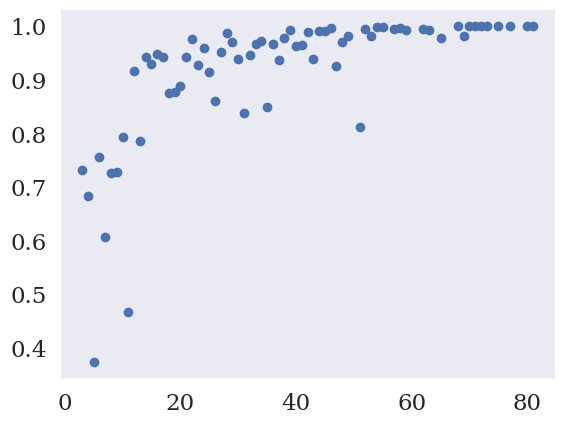

In [104]:
grouped = grid_data.groupby('num_clicks').agg({
    'uLSC': list,
    'fLSCp': list
})

# Define a function to calculate the correlation between two lists
def calculate_corr(x):
    return np.corrcoef(x['uLSC'], x['fLSCp'])[0, 1]

# Apply the correlation function to each group
grouped['correlation'] = grouped.apply(calculate_corr, axis=1)

# Display the result
plt.scatter(grouped['correlation'].reset_index()["num_clicks"], grouped['correlation'].reset_index()["correlation"])

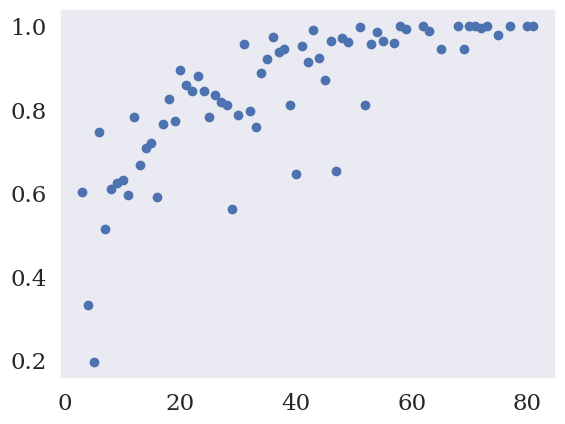

In [107]:
grouped = grid_data.groupby('num_clicks').agg({
    'uInt': list,
    'fIntp': list
})

# Define a function to calculate the correlation between two lists
def calculate_corr(x):
    return np.corrcoef(x['uInt'], x['fIntp'])[0, 1]

# Apply the correlation function to each group
grouped['correlation'] = grouped.apply(calculate_corr, axis=1)

# Display the result
plt.scatter(grouped['correlation'].reset_index()["num_clicks"], grouped['correlation'].reset_index()["correlation"])

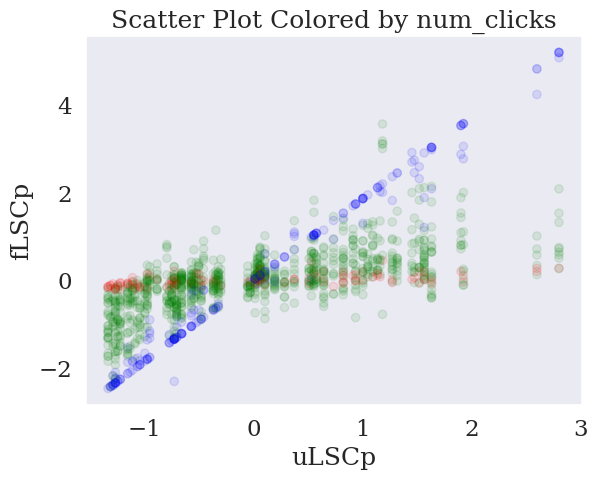

In [91]:
mean_clicks = grid_data["num_clicks"].mean()
std_clicks = grid_data["num_clicks"].std()

# Define color based on the conditions
conditions = [
    (grid_data["num_clicks"] > mean_clicks + std_clicks),
    (grid_data["num_clicks"] < mean_clicks - std_clicks)
]

choices = ['blue', 'red']

# Create the scatter plot
plt.scatter(grid_data["uInt"], grid_data["fIntp"], c=np.select(conditions, choices, default='green'), alpha=0.1)

# Add labels and title
plt.xlabel("uLSCp")
plt.ylabel("fLSCp")
plt.title("Scatter Plot Colored by num_clicks")
# Display the plot
plt.show()

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Select numeric columns, excluding 'num_clicks'
numeric_cols = grid_data.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_to_scale = numeric_cols.drop('num_clicks')

# Fit and transform the selected numeric columns
grid_data[numeric_cols_to_scale] = scaler.fit_transform(grid_data[numeric_cols_to_scale])

(-2.0, 2.0)

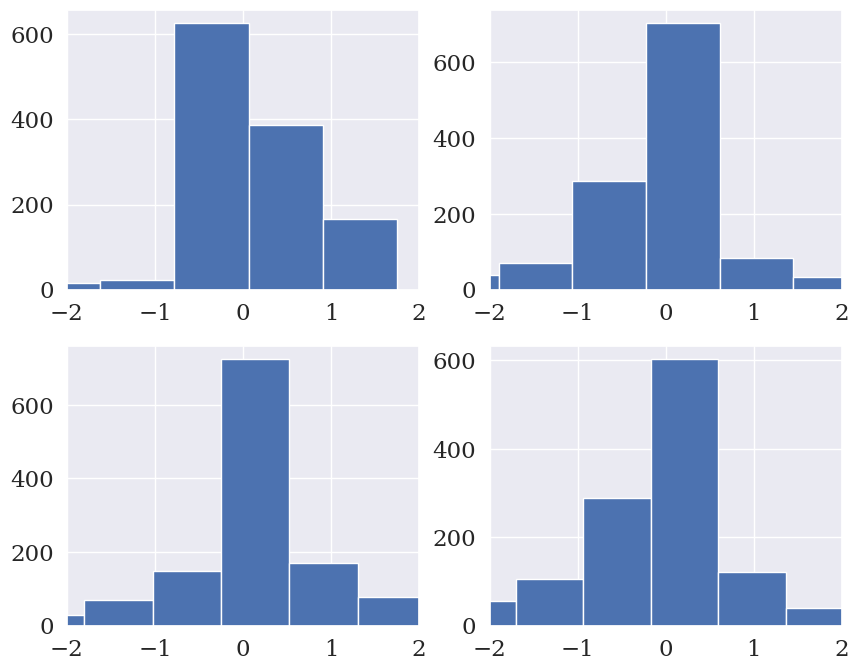

In [153]:
fig, ax = plt.subplots(2,2, figsize = (10, 8))
ax[0,0].hist(grid_data["uLSCp"])
ax[0,0].set_xlim(-2, 2)
ax[0,1].hist(grid_data["uIntp"])
ax[0,1].set_xlim(-2, 2)
ax[1,0].hist(grid_data["fLSCp"])
ax[1,0].set_xlim(-2, 2)
ax[1,1].hist(grid_data["fIntp"])
ax[1,1].set_xlim(-2, 2)


In [154]:
grid_data["fLSCpsq"] = grid_data["fLSCp"] ** 2
grid_data["fIntpsq"] = grid_data["fIntp"] ** 2
grid_data["fLSCpsq"] = scaler.fit_transform(grid_data[["fLSCpsq"]])
grid_data["fIntpsq"] = scaler.fit_transform(grid_data[["fIntpsq"]])

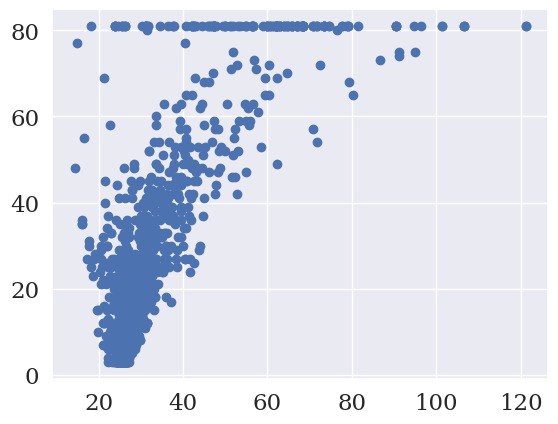

In [159]:
# plt.scatter(8.56 * grid_data["fLSCp"] - 19.1 * grid_data["fIntp"] + 6.73 * grid_data["uLSCp"] + 9.63 * grid_data["uIntp"] + 3.88 * grid_data["fLSCp"] * grid_data["uLSCp"] + 3.59 * grid_data["fIntp"] * grid_data["uIntp"], grid_data["num_clicks"])
# plt.xlim(0, 80)
plt.scatter(34.52 + 13.17 * grid_data["fLSCp"] + 13.82 * grid_data["fLSCpsq"] - 8.84 * grid_data["fIntp"] + 10.72 * grid_data["fIntpsq"] - 1.67 * grid_data["fLSCp"] * grid_data["fIntp"], grid_data["num_clicks"])

In [25]:
mean_clicks + std_clicks

np.float64(53.780142124400825)

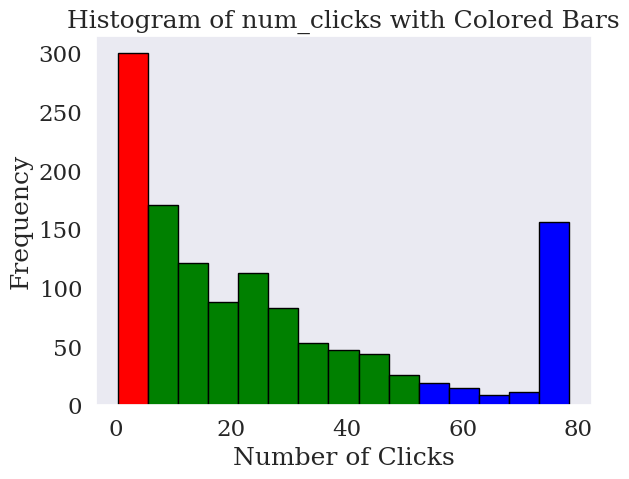

In [22]:
counts, bin_edges = np.histogram(grid_data["num_clicks"], bins=15)

# Plot each bar individually with the appropriate color
for i in range(len(counts)):
    if bin_edges[i] < (mean_clicks - std_clicks):
        color = 'red'
    elif bin_edges[i] > (mean_clicks + std_clicks):
        color = 'blue'
    else:
        color = 'green'
    
    plt.bar(bin_edges[i], counts[i], width=bin_edges[i+1] - bin_edges[i], color=color, edgecolor='black')

# Add labels and title
plt.xlabel("Number of Clicks")
plt.ylabel("Frequency")
plt.title("Histogram of num_clicks with Colored Bars")

# Display the plot
plt.show()

(array([394., 198., 153., 131.,  78.,  66.,  35.,  25.,  16., 160.]),
 array([ 3. , 10.8, 18.6, 26.4, 34.2, 42. , 49.8, 57.6, 65.4, 73.2, 81. ]),
 <BarContainer object of 10 artists>)

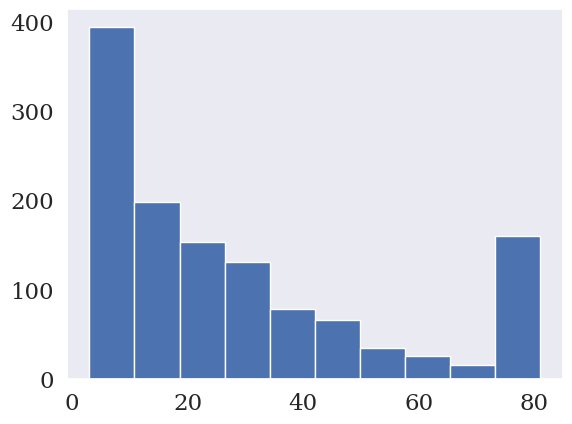

In [20]:
plt.hist(grid_data["num_clicks"])

In [ ]:
max(pd.read_csv("utils/grid_data.csv").groupby("Subject").agg(max)["grid_id"])

In [ ]:
for df in os.listdir("../../data/grid-search/"):
    if df[0:4] != "data":
        continue
    with open("../../data/grid-search/" + df) as f:
        d = json.load(f)
        print(df, d["trials"][0]["num_grids_visited"])

## People who revisited patterns

In [ ]:
for pid, count in grid_data.groupby("pid").count()["grid_id"].items():
    if count > 98:
        print(f"PID {pid} visited {count} grids. Therefore revisited {count - 98} grids.")